## DATA 512: Assignment 1
### Natasha Halfin
### October 8, 2020

### Step 1: Gathering the Data
First, I will import all needed packages.

In [1]:
#import packages
import json
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

Next, I will store endpoints for the legacy API and the current Pageview API for Wikipedia.

In [2]:
#create endpoints for legacy and current APIs
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

The Legacy API has two access-sites: desktop and mobile. The Pageview API has three access-sites: desktop, mobile web, and mobile app. Below, I define parameters for each access-site that corresponds to each API.

In [3]:
#set parameters for each query type in each API
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }
params_pageviews_mobileweb = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }

params_pageviews_mobileapp = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }

headers = {
    'User-Agent': 'https://github.com/nhalfi',
    'From': 'nhalfin@uw.edu'
}

Here, I define a function called api_call where I will pass the desired combination of endpoint and parameters, as I have defined above.

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Now I will call the api_call function and store the page view data for each API and access-site combination in corresponding variables.

In [5]:
#call APIs with given parameters to generate monthly counts

#PageCount API
pagecounts_desktop = api_call(endpoint_legacy, params_legacy_desktop)
pagecounts_mobile = api_call(endpoint_legacy, params_legacy_mobile)

#PageView API
pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobileweb)
pageviews_mobileapp = api_call(endpoint_pageviews, params_pageviews_mobileapp)

Next, I will save the previous API output in separate JSON files.

In [26]:
#save output to individual JSON files
with open('pagecounts_desktop-site_200801-201607.json','w') as f:
    json.dump(pagecounts_desktop,f)
with open('pagecounts_mobile-site_200801-201607.json','w') as f:
    json.dump(pagecounts_mobile,f)
with open('pageviews_desktop_201507-202008.json','w') as f:
    json.dump(pageviews_desktop,f)
with open('pageviews_mobile-web_201507-202008.json','w') as f:
    json.dump(pageviews_mobileweb,f)
with open('pageviews_mobile-app_201507-202008.json','w') as f:
    json.dump(pageviews_mobileapp,f)

### Step 2: Processing the Data
First, I will create a list containing the relevant JSON file names.

In [21]:
#read JSON files as dataframes
files = []
for file in os.listdir():
    if file.endswith('.json'):
        files.append(file)



Next, I will create a list to store a dataframe for each API query result.

In [22]:
#create dataframe names for each API result
df_names = []
for i in range(len(files)):
    file_split = files[i].split('_')
    df_name = "df_" + file_split[0] +"_"+ file_split[1]
    df_names.append(df_name)

Next, I will read in each JSON file and store it as a dataframe.

In [23]:
for i in range(len(files)):
    df_names[i] = pd.read_json(files[i])

Now, I will parse the JSON object to obtain the primary datapoints of interest: timestamp and count. I have created two different for loops for each API result because the JSON objects vary slightly between each API.

In [24]:
for i in range(0,2):
    with open(files[i]) as json_data:
        obj = json.load(json_data)
    df_names[i] = pd.DataFrame(obj['items'], columns=['timestamp','count'])

for i in range(2,5):
    with open(files[i]) as json_data:
        obj = json.load(json_data)
    df_names[i] = pd.DataFrame(obj['items'], columns=['timestamp','views'])



Next, I will rename the count and view volumns to be more specific to the API and query type.

In [25]:
df_names[0] = df_names[0].rename(columns = {"count":"pagecount_desktop_views"})
df_names[1] = df_names[1].rename(columns = {"count":"pagecount_mobile_views"})
df_names[2] = df_names[2].rename(columns = {"views":"pageview_desktop_views"})
df_names[3] = df_names[3].rename(columns = {"views":"pageview_mobileapp_views"})
df_names[4] = df_names[4].rename(columns = {"views":"pageview_mobileweb_views"})

Next, I will join each dataframe on the common timestamp column to create a single dataframe representing all Wikipedia page views.

In [26]:
df_allviews = df_names[0].merge(df_names[1],how= "outer",on = "timestamp")
df_allviews = df_allviews.merge(df_names[2],how= "outer",on = "timestamp")
df_allviews = df_allviews.merge(df_names[3],how= "outer",on = "timestamp")
df_allviews = df_allviews.merge(df_names[4],how= "outer",on = "timestamp")

Then, I will replace any NA values (pertaining to months when a certain API was not in usage) with 0s. I will also create a calculated column that combines the Pageview API mobile web and mobile app views.

In [27]:
df_allviews = df_allviews.fillna(0)
df_allviews['pageview_mobile_views'] = df_allviews['pageview_mobileapp_views'].values + df_allviews['pageview_mobileweb_views'].values

I'll also create calculated columns that sum the total views for each API (Pagecount/Legacy and Pageview).

In [28]:
df_allviews['pagecount_all_views'] = df_allviews['pagecount_desktop_views'].values + df_allviews['pagecount_mobile_views'].values
df_allviews['pageview_all_views'] = df_allviews['pageview_desktop_views'].values + df_allviews['pageview_mobile_views'].values

Next, I'll create a separate year and month column by taking substrings from the timestamp column.

In [29]:
df_allviews['year'] = df_allviews['timestamp'].str[:4]
df_allviews['month'] = df_allviews['timestamp'].str[4:6]

Then, I will save a new dataframe with the desired columns I'd like to retain, and save this new dataframe as a csv file.

In [30]:
df_consolidated = df_allviews[['year','month', 'pagecount_all_views', 'pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]
df_consolidated.to_csv('en-wikipedia_traffic_200712-202008.csv',index = False)

### Step 3: Analyze the Data
Now, I will continue to transform my dataframe to allow for easy visualization. First, I will convert the page view count columns to an integer data type.

In [31]:
df_consolidated[['pagecount_all_views', 'pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']] = df_consolidated[['pagecount_all_views', 'pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']].apply(np.int64)

Next, I will divide all the previous integer columns by 1 million in order to scale the visualization and make it easier to interpret the y-axis values.

In [32]:
df_consolidated[['pagecount_all_views', 'pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']] = df_consolidated[['pagecount_all_views', 'pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]/1000000

I will also add a column that concatenates the year and month columns, and convert this to a datetime data type.

In [33]:
df_consolidated['year-month'] = df_consolidated['year']+"-"+ df_consolidated['month']
df_consolidated['year-month'] = pd.to_datetime(df_consolidated['year-month'])

Next, I will revert 0 values back to NA in order to prevent strange jumps in the data when a new API or access-site became available.

In [34]:
df_consolidated = df_consolidated.replace(0,np.nan)

Finally, I am ready to plot a time series graph depicting page views from each API on Wikipedia from January 2008 through August 2020. I customized the figure size to make the x-axis longer, I included a plot title and axis labels, I moved the legend location, and I also customized the x-axis tick values.

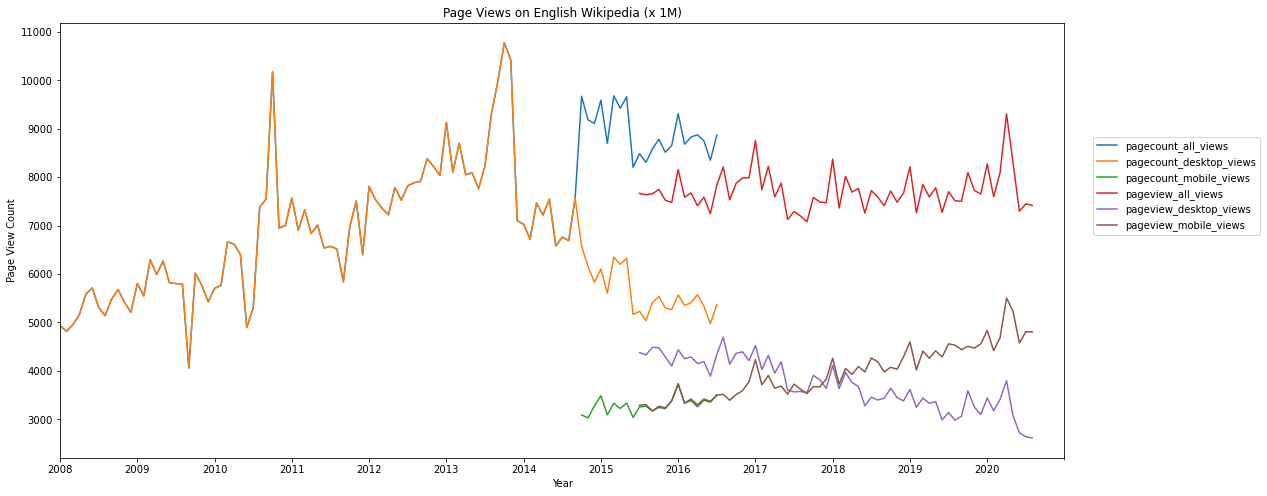

In [38]:

df_consolidated[['year-month','pagecount_all_views', 'pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']].plot('year-month',figsize = (18,8))
plt.xlim('2008','2021')
plt.xlabel("Year")
plt.ylabel("Page View Count")
plt.title("Page Views on English Wikipedia (x 1M)")
plt.legend(bbox_to_anchor=(1.2, 0.75))
yearmin = np.datetime64(df_consolidated['year-month'].min(),'Y')
yearmax = np.datetime64(df_consolidated['year-month'].max(),'Y')+np.timedelta64(1,'Y')
plt.xticks(np.arange(yearmin,yearmax,1),df_consolidated['year'].unique())


plt.show()
